In [20]:
import pandas as pd
import datetime
from my_pysyncon import Dataprep, Synth, AugSynth

In [21]:
df_mo = pd.read_csv('../../../Dataset_Generation/Jared/Data/total_state_data.csv')
df_mo['co2_per_capita'] = df_mo['monthly_emissions'] / df_mo['population']
df_mo['gdp_per_capita'] = df_mo['gdp_rel_2017_interp'] / df_mo['population']
df_mo['eprod_per_capita'] = df_mo['energy_prod'] / df_mo['population']
df_mo['eflow_per_capita'] = df_mo['energy_flow'] / df_mo['population']

df_yr = pd.read_csv('../../../Dataset_Generation/Jared/Data/yearly_total_data.csv')
df_yr['co2_per_capita'] = df_yr['total_co2'] / df_yr['population']
df_yr['gdp_per_capita'] = df_yr['yearly_gdp_rel_2017'] / df_yr['population']
df_yr['eprod_per_capita'] = df_yr['energy_prod'] / df_yr['population']
df_yr['eflow_per_capita'] = df_yr['energy_flow'] / df_yr['population']

In [22]:
time_range = df_mo.date

# these are the time values where CO2 emissions are fit
preintervention_time_range = df_mo.date[df_mo.date<'2009-01-01']

# these are the time values where our features are fit (subset of preintervention_time_range)
preintervention_feature_range = df_mo.date[(df_mo.date >= '1997-01-01') & (df_mo.date<'2009-01-01')]
preintervention_weather_range = df_mo.date[(df_mo.date >= '1990-01-01') & (df_mo.date<'2009-01-01')]
preintervention_gdp_range = df_mo.date[(df_mo.date >= '1997-12-01') & (df_mo.date<'2009-01-01')]

# these are the dates used for our monthly graph and for
years= pd.date_range(start='1990-01-01', end='2019-12-01', freq='MS').strftime('%Y-%m-%d').tolist()

We prepare the study data using a `Dataprep` object that describes all the details needed to define the synthetic control study. This works similarly to the `dataprep` method in the `R` package `synth`.

(For an explanation of each of the `Dataprep` arguments, see the package [documentation](https://sdfordham.github.io/pysyncon/dataprep.html#pysyncon.Dataprep)).

In [23]:
# we leave off RGGI states, states with no CO2 data (AK, HI), as well as states with some type of cap-and-trade program (CA)

rggi_states = ['CT', 'DE', 'ME', 'MD', 'MA', 'NH', 'NJ', 'NY', 'RI', 'VT', 'VA']

non_rggi_controls_identifier= [
    "AL", 
    #"AK", 
    "AZ", "AR", 
    #"CA", 
    "CO", 
    #"CT", 
    #"DE", 
    "FL", 
    "GA",
    #"HI", 
    "ID", "IL", "IN", "IA", "KS", "KY", "LA", 
    #"ME", 
    #"MD",
    #"MA", 
    "MI", "MN", "MS", "MO", "MT", "NE", "NV", 
    #"NH", 
    #"NJ",
    "NM", "NC", "ND", "OH", "OK", "OR", "PA", 
    #"RI", 
    "SC", "SD", "TN", "TX", "UT", 
    #"VT", 
    #"VA", 
    "WA", "WV", "WI", "WY"
    ]

In [24]:
# we create a synthetic control Delaware as applied to monthly data

dataprep_mo = Dataprep(
    foo=df_mo,
    predictors=['snow', 'prcp', 'tavg', 'gdp_per_capita', 'eprod_per_capita', 'eflow_per_capita'],
    predictors_op="mean",
    time_predictors_prior=preintervention_feature_range,
    dependent="co2_per_capita",
    unit_variable="state",
    time_variable="date",
    treatment_identifier="DE",
    controls_identifier= non_rggi_controls_identifier,
    time_optimize_ssr=preintervention_time_range
)

print(dataprep_mo)

Dataprep
Treated unit: DE
Dependent variable: co2_per_capita
Control units: AL, AZ, AR, CO, FL, GA, ID, IL, IN, IA, KS, KY, LA, MI, MN, MS, MO, MT, NE, NV, NM, NC, ND, OH, OK, OR, PA, SC, SD, TN, TX, UT, WA, WV, WI, WY
Time range in data: 1990-01-01 - 2024-12-01
Time range for loss minimization: 0        1990-01-01
1        1990-02-01
2        1990-03-01
3        1990-04-01
4        1990-05-01
            ...    
11167    2008-08-01
11168    2008-09-01
11169    2008-10-01
11170    2008-11-01
11171    2008-12-01
Name: date, Length: 11172, dtype: object
Time range for predictors: 4116     1997-01-01
4117     1997-02-01
4118     1997-03-01
4119     1997-04-01
4120     1997-05-01
            ...    
11167    2008-08-01
11168    2008-09-01
11169    2008-10-01
11170    2008-11-01
11171    2008-12-01
Name: date, Length: 7056, dtype: object
Predictors: snow, prcp, tavg, gdp_per_capita, eprod_per_capita, eflow_per_capita



In [25]:
# we create a synthetic control Delaware as applied to yearly data

dataprep_yr = Dataprep(
    foo=df_yr,
    predictors=['snow', 'prcp', 'tavg', 'gdp_per_capita', 'eprod_per_capita', 'eflow_per_capita'],
    predictors_op="mean",
    time_predictors_prior=range(1997,2010),
    dependent="co2_per_capita",
    unit_variable="state",
    time_variable="year",
    treatment_identifier="DE",
    controls_identifier= non_rggi_controls_identifier,
    time_optimize_ssr=range(1990,2010)
)

print(dataprep_yr)

Dataprep
Treated unit: DE
Dependent variable: co2_per_capita
Control units: AL, AZ, AR, CO, FL, GA, ID, IL, IN, IA, KS, KY, LA, MI, MN, MS, MO, MT, NE, NV, NM, NC, ND, OH, OK, OR, PA, SC, SD, TN, TX, UT, WA, WV, WI, WY
Time range in data: 1990.0 - 2024.0
Time range for loss minimization: range(1990, 2010)
Time range for predictors: range(1997, 2010)
Predictors: snow, prcp, tavg, gdp_per_capita, eprod_per_capita, eflow_per_capita




We supply the `Dataprep` object to a `Synth` object. The optimization scheme we could use is [BFGS](https://docs.scipy.org/doc/scipy/reference/optimize.minimize-bfgs.html) and the starting point we could use for the optimisation is `ols` i.e. the initial weights are obtained by fitting an ordinary-least-squares estimate. (Unlike the `R` package `synth` which performs four different runs under the hood (two different starting points and two different optimisation schemes), in this package only one optimisation is run per `fit`).

*Nota bene that the weights obtained by the synthetic control method are often highly sensitive to the chosen optimisation scheme and starting point.*

In [26]:
# monthly version

synth_mo = Synth()
synth_mo.fit(dataprep=dataprep_mo)
print(synth_mo.weights(threshold=.01))

IL    0.477
MN    0.013
NV    0.510
Name: weights, dtype: float64


This is saying that Delaware is $49.3\%$ Illinois, $49.1\%$ Nevada, and $1.5\%$ Minnesota (all other percentages are negligible).


In [27]:
# yearly version

synth_yr= Synth()
synth_yr.fit(dataprep=dataprep_yr,optim_initial='ols')
print(synth_yr.weights(threshold=.01))

IL    0.189
MN    0.187
NV    0.623
Name: weights, dtype: float64


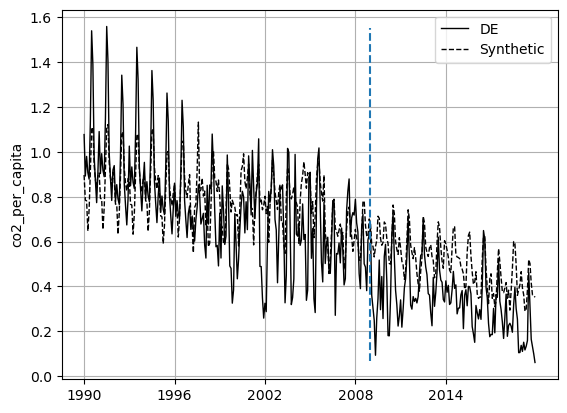

In [28]:
# Monthly synthetic control plot

synth_mo.path_plot(time_period=years, treatment_time='2009-01-01')

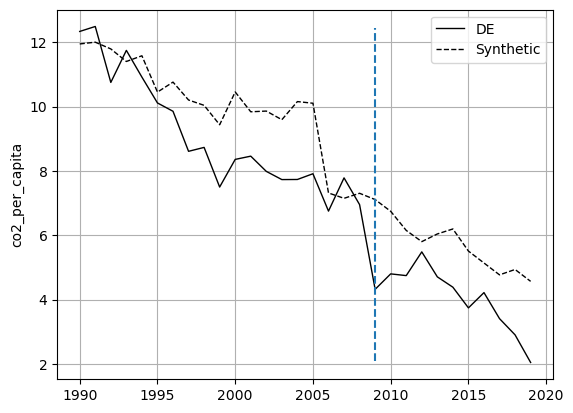

In [29]:
# Yearly synthetic control plot

synth_yr.path_plot_orig(time_period=range(1990,2020), treatment_time=2009)

The summary function give more information on the predictor values. The first column shows the value of the $V$ matrix for each predictor, the column 'treated' shows the mean value of each predictor for the treated unit over the time period `time_predictors_prior`, the column 'synthetic' shows the mean value of each predictor for the synthetic control over the time period `time_predictors_prior` and finally the column 'sample mean' shows the sample mean of that predictor for all control units over the time period `time_predictors_prior` i.e. this is the same as the synthetic control with all weights equal.

In [30]:
synth_mo.summary()

,V,treated,synthetic,sample mean
snow,0.350,0.829,0.773,1.660
prcp,0.000,3.916,1.644,2.694
tavg,0.011,57.259,60.378,56.197
gdp_per_capita,0.078,0.006,0.005,0.004
eprod_per_capita,0.078,0.002,0.077,0.798
eflow_per_capita,0.483,-0.354,-0.225,0.404


In [31]:
synth_yr.summary()

,V,treated,synthetic,sample mean
snow,0.001,0.921,1.622,1.683
prcp,0.000,4.047,1.257,2.724
tavg,0.000,57.407,60.467,56.125
gdp_per_capita,0.001,0.078,0.057,0.046
eprod_per_capita,0.109,0.002,0.044,0.801
eflow_per_capita,0.889,-0.348,-0.257,0.410


## RGGI State Synthetic Control Comparisons

First, we compare the RGGI synthetic controls at the monthly level.

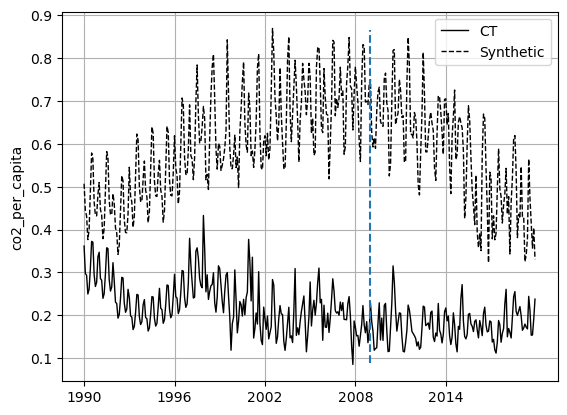

State: CT 

IL    0.97
MN    0.03
Name: weights, dtype: float64 

                              V  treated  synthetic  sample mean
eprod_per_capita          0.096    0.049      0.147        0.798
eflow_per_capita          0.148   -0.191     -0.172        0.404
special.1.snow            0.062    2.519      1.105        1.703
special.2.prcp            0.489    3.634      3.062        2.755
special.3.gdp_per_capita  0.205    0.006      0.005        0.004


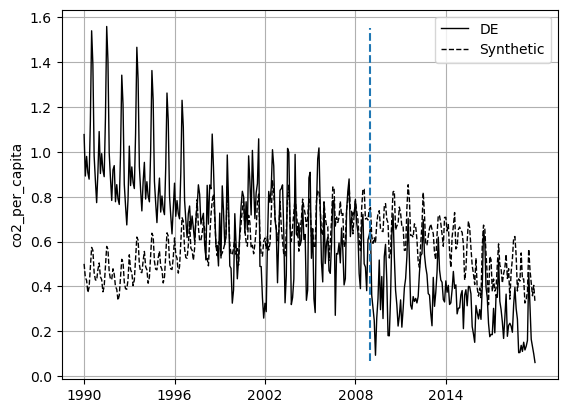

State: DE 

IL    1.0
Name: weights, dtype: float64 

                              V  treated  synthetic  sample mean
eprod_per_capita          0.198    0.002      0.151        0.798
eflow_per_capita          0.208   -0.354     -0.168        0.404
special.1.snow            0.198    0.800      0.906        1.703
special.2.prcp            0.198    3.840      3.076        2.755
special.3.gdp_per_capita  0.198    0.006      0.005        0.004


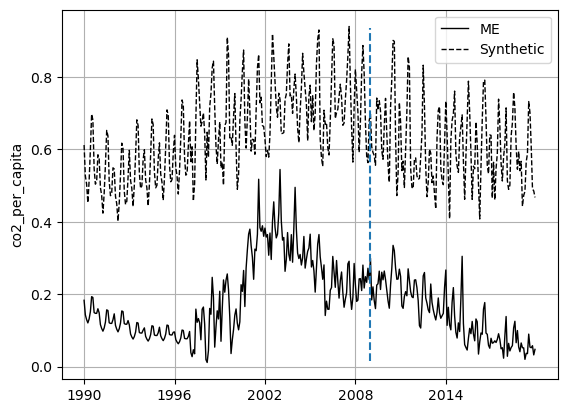

State: ME 

LA    0.028
MN    0.570
MS    0.402
Name: weights, dtype: float64 

                              V  treated  synthetic  sample mean
eprod_per_capita          0.495    0.100      0.102        0.798
eflow_per_capita          0.007   -0.224     -0.290        0.404
special.1.snow            0.113    5.544      4.320        1.703
special.2.prcp            0.346    3.958      3.453        2.755
special.3.gdp_per_capita  0.039    0.004      0.004        0.004


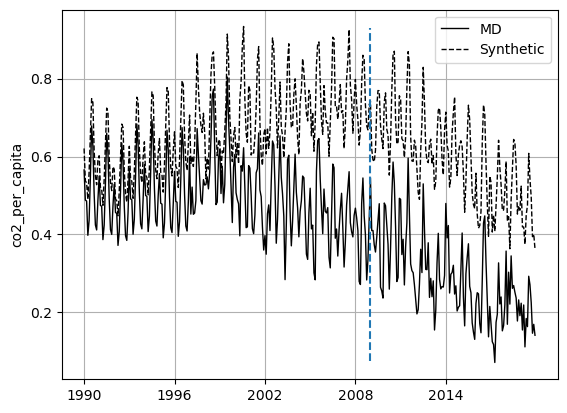

State: MD 

FL    0.071
GA    0.168
IL    0.511
LA    0.119
MN    0.130
Name: weights, dtype: float64 

                              V  treated  synthetic  sample mean
eprod_per_capita          0.188    0.052      0.166        0.798
eflow_per_capita          0.203   -0.217     -0.226        0.404
special.1.snow            0.205    1.467      1.466        1.703
special.2.prcp            0.215    3.534      3.525        2.755
special.3.gdp_per_capita  0.189    0.004      0.004        0.004


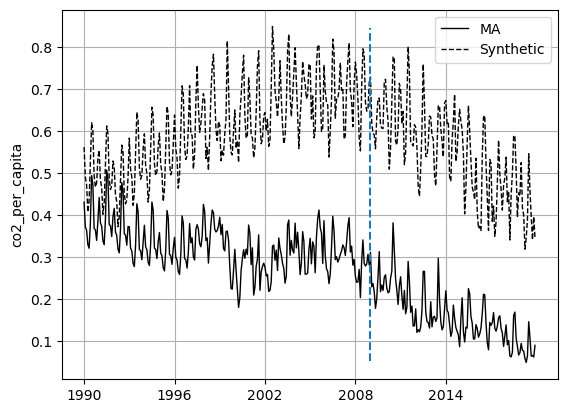

State: MA 

IL    0.699
MN    0.301
Name: weights, dtype: float64 

                              V  treated  synthetic  sample mean
eprod_per_capita          0.222    0.016      0.120        0.798
eflow_per_capita          0.248   -0.214     -0.209        0.404
special.1.snow            0.052    3.959      2.905        1.703
special.2.prcp            0.198    3.641      2.936        2.755
special.3.gdp_per_capita  0.280    0.005      0.005        0.004


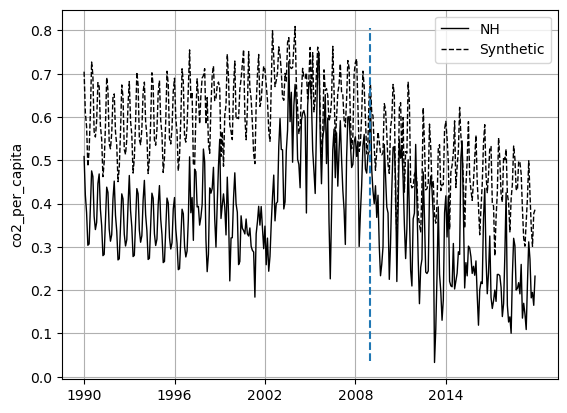

State: NH 

MN    1.0
Name: weights, dtype: float64 

                              V  treated  synthetic  sample mean
eprod_per_capita          0.199    0.096      0.049        0.798
eflow_per_capita          0.198   -0.142     -0.304        0.404
special.1.snow            0.198   22.829      7.550        1.703
special.2.prcp            0.206    7.918      2.610        2.755
special.3.gdp_per_capita  0.199    0.004      0.005        0.004


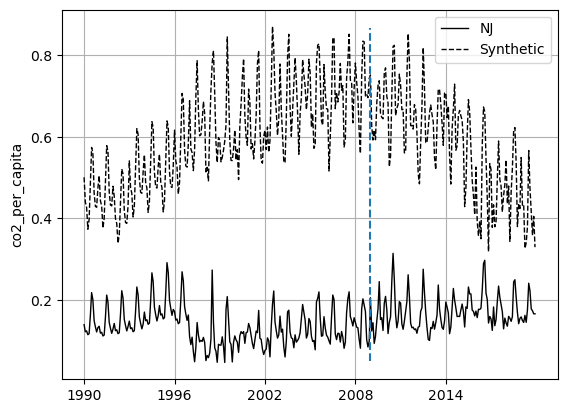

State: NJ 

IL    1.0
Name: weights, dtype: float64 

                              V  treated  synthetic  sample mean
eprod_per_capita          0.206    0.039      0.151        0.798
eflow_per_capita          0.218   -0.258     -0.168        0.404
special.1.snow            0.149    1.071      0.906        1.703
special.2.prcp            0.209    3.508      3.076        2.755
special.3.gdp_per_capita  0.218    0.005      0.005        0.004


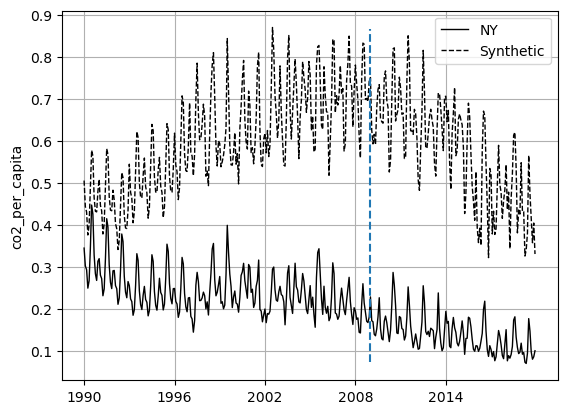

State: NY 

IL    0.978
MN    0.022
Name: weights, dtype: float64 

                              V  treated  synthetic  sample mean
eprod_per_capita          0.267    0.035      0.148        0.798
eflow_per_capita          0.201   -0.168     -0.171        0.404
special.1.snow            0.059    1.920      1.051        1.703
special.2.prcp            0.275    3.532      3.066        2.755
special.3.gdp_per_capita  0.197    0.005      0.005        0.004


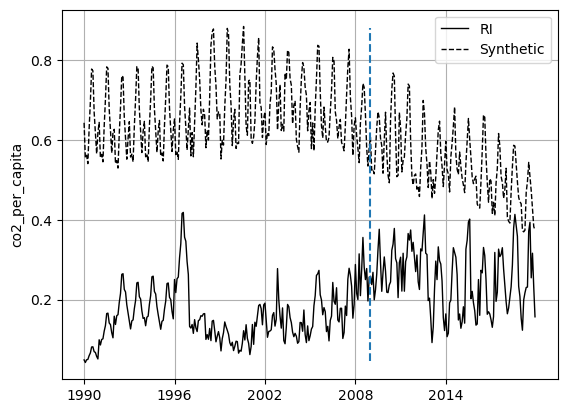

State: RI 

FL    0.568
LA    0.078
MN    0.347
Name: weights, dtype: float64 

                              V  treated  synthetic  sample mean
eprod_per_capita          0.087    0.003      0.104        0.798
eflow_per_capita          0.261   -0.196     -0.233        0.404
special.1.snow            0.231    2.640      2.634        1.703
special.2.prcp            0.185    3.890      3.879        2.755
special.3.gdp_per_capita  0.236    0.004      0.004        0.004


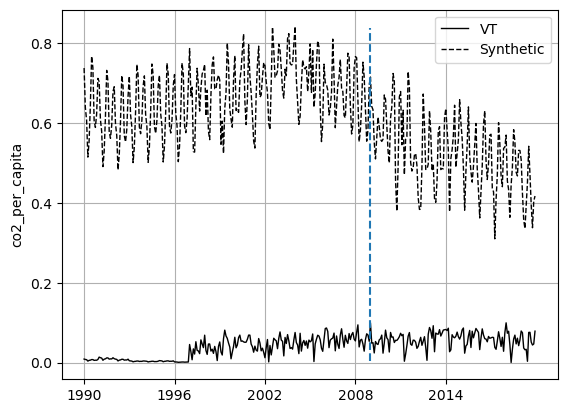

State: VT 

LA    0.042
MN    0.954
Name: weights, dtype: float64 

                              V  treated  synthetic  sample mean
eprod_per_capita          0.217    0.096      0.136        0.798
eflow_per_capita          0.328   -0.139     -0.243        0.404
special.1.snow            0.342    7.324      7.221        1.703
special.2.prcp            0.112    3.078      2.711        2.755
special.3.gdp_per_capita  0.001    0.004      0.005        0.004


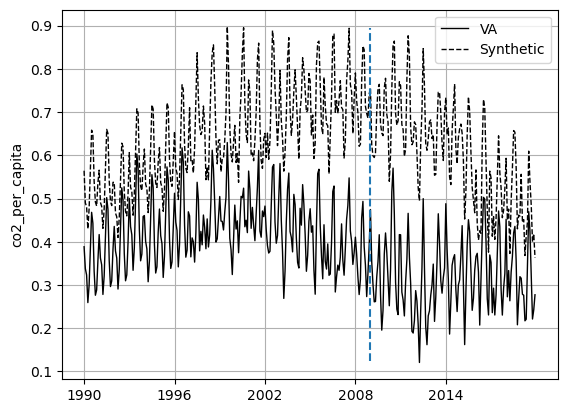

State: VA 

FL    0.045
IL    0.698
LA    0.115
MN    0.034
NC    0.052
WA    0.020
Name: weights, dtype: float64 

                              V  treated  synthetic  sample mean
eprod_per_capita          0.198    0.176      0.202        0.798
eflow_per_capita          0.199   -0.153     -0.183        0.404
special.1.snow            0.194    1.036      1.037        1.703
special.2.prcp            0.201    3.364      3.361        2.755
special.3.gdp_per_capita  0.208    0.005      0.005        0.004


In [32]:
# loop through all RGGI states to see their monthly graphs

for state in rggi_states:
    dataprep_mo = Dataprep(
    foo=df_mo,
    predictors=['eprod_per_capita', 'eflow_per_capita'], # 'tavg'
    predictors_op="mean",
    time_predictors_prior=preintervention_feature_range,
    special_predictors=[
        ("snow", preintervention_weather_range, "mean"),
        ('prcp', preintervention_weather_range, "mean"),
        ('gdp_per_capita', preintervention_gdp_range, "mean")
    ],
    dependent="co2_per_capita",
    unit_variable="state",
    time_variable="date",
    treatment_identifier=state,
    controls_identifier= non_rggi_controls_identifier,
    time_optimize_ssr=preintervention_time_range
    )

    # monthly version

    synth_mo = Synth()
    synth_mo.fit(dataprep=dataprep_mo)

    synth_mo.path_plot(time_period=years, treatment_time='2009-01-01')

    print('State:', state,'\n')
    print(synth_mo.weights(threshold=.01),'\n')
    print(synth_mo.summary())
    